In [1]:
# !pip uninstall torch torchvision torchaudio transformers datasets -y
# !pip cache purge

# # Install a known-good, compatible stack
# !pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
# !pip install transformers==4.41.2 datasets==2.19.2 rouge-score==0.1.2 scikit-learn matplotlib seaborn numpy tqdm
# !pip install sentencepiece

In [2]:
import json
import os
import time
import warnings
from collections import defaultdict
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from rouge_score import rouge_scorer
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from transformers import (
    MT5ForConditionalGeneration,
    MT5Tokenizer,
    get_linear_schedule_with_warmup,
)

warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class Config:
    model_name = "google/mt5-small"
    languages = ["english", "hindi", "punjabi"]
    num_experts = 6
    top_k = 3
    capacity_factor = 1.25
    max_input_length = 512
    max_target_length = 128

    # ===== TRAINING HYPERPARAMETERS =====
    batch_size = 8 
    gradient_accumulation_steps = 8  # Effective batch size = 64
    learning_rate = 5e-4  
    num_epochs = 10
    warmup_steps = 500  
    weight_decay = 0.01
    
    # MoE-specific hyperparameters
    aux_loss_weight_start = 0.001
    aux_loss_weight_end = 0.01
    aux_loss_warmup_steps = 1000  # Gradual aux loss warmup
    
    gradient_clip_val = 1.0
    expert_dropout = 0.1
    
    # Generation settings
    num_beams = 4
    generation_max_length = 128
    
    # Logging and validation
    LOG_INTERVALS = 500
    VALIDATION_INTERVALS = 999999  # End-of-epoch validation only
    validation_subset_size = 200
    max_val_generation_batches = 100
    num_workers = 4  # Balanced for performance
    
    train_size = None  
    val_size = None    
    test_size = None  
    
    # Checkpointing
    checkpoint_dir = "./checkpoints"
    save_every_n_epochs = 1
    save_best_only = True
    best_metric = "rougeL"
    patience = 5  # Early stopping patience
    min_delta = 0.0001  # Minimum improvement threshold
    
    log_grad_norms = False
    grad_norm_log_interval = 100
    
    def validate(self):
        assert self.top_k <= self.num_experts
        assert self.capacity_factor >= 1.0
        assert len(self.languages) <= self.num_experts
        assert self.batch_size > 0
        assert self.learning_rate > 0
        
        if self.train_size is not None:
            assert self.train_size > 0
        if self.val_size is not None:
            assert self.val_size > 0
        if self.test_size is not None:
            assert self.test_size > 0
        
        print("=" * 60)
        print("CONFIGURATION FOR FULL DATASET TRAINING")
        print("=" * 60)
        print(f"Model: {self.model_name}")
        print(f"Languages: {', '.join(self.languages)}")
        print(f"Experts: {self.num_experts} (top-{self.top_k})")
        print(f"Batch size: {self.batch_size}")
        print(f"Gradient accumulation: {self.gradient_accumulation_steps}")
        print(f"Effective batch size: {self.batch_size * self.gradient_accumulation_steps}")
        print(f"Learning rate: {self.learning_rate}")
        print(f"Epochs: {self.num_epochs}")
        print(f"Warmup steps: {self.warmup_steps}")
        print(f"Dataset: FULL (train_size={self.train_size}, val_size={self.val_size}, test_size={self.test_size})")
        print(f"Checkpoint dir: {self.checkpoint_dir}")
        print(f"Early stopping patience: {self.patience}")
        print("=" * 60)
        return True


In [4]:
config = Config()
config.validate()  # Validate configuration before using it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create checkpoint directory with timestamp
from datetime import datetime
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
config.checkpoint_dir = f"./checkpoints/moe_xlsum_{timestamp}"
os.makedirs(config.checkpoint_dir, exist_ok=True)

print(f"\n✓ Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"✓ Checkpoints: {config.checkpoint_dir}")
print(f"✓ Dataset mode: {'FULL' if config.train_size is None else f'SUBSET ({config.train_size} samples)'}")


CONFIGURATION FOR FULL DATASET TRAINING
Model: google/mt5-small
Languages: english, hindi, punjabi
Experts: 6 (top-3)
Batch size: 8
Gradient accumulation: 8
Effective batch size: 64
Learning rate: 0.0005
Epochs: 10
Warmup steps: 500
Dataset: FULL (train_size=None, val_size=None, test_size=None)
Checkpoint dir: ./checkpoints
Early stopping patience: 5

✓ Device: cuda
✓ GPU: NVIDIA H100 80GB HBM3 MIG 3g.40gb
✓ GPU Memory: 39.38 GB
✓ Checkpoints: ./checkpoints/moe_xlsum_20251104_210357
✓ Dataset mode: FULL


In [5]:
class ModelCheckpoint:
    def __init__(
        self,
        checkpoint_dir,
        save_best_only=True,
        best_metric="rouge1",
        patience=None,
        min_delta=0.001,
    ):
        self.checkpoint_dir = checkpoint_dir
        self.save_best_only = save_best_only
        self.best_metric = best_metric
        self.patience = patience
        self.min_delta = min_delta

        self.best_score = float("-inf")
        self.best_epoch = 0
        self.patience_counter = 0
        self.should_stop = False

        self.best_model_dir = os.path.join(checkpoint_dir, "best_model")
        self.epoch_checkpoints_dir = os.path.join(
            checkpoint_dir, "epoch_checkpoints")

        os.makedirs(self.best_model_dir, exist_ok=True)
        os.makedirs(self.epoch_checkpoints_dir, exist_ok=True)

    def save_checkpoint(
        self,
        model,
        optimizer,
        scheduler,
        epoch,
        train_loss,
        val_loss,
        rouge_scores,
        training_history,
    ):
        checkpoint_data = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "train_loss": train_loss,
            "val_loss": val_loss,
            "rouge_scores": rouge_scores,
            "training_history": training_history,
            "config": config.__dict__,
            "best_score": self.best_score,
            "best_epoch": self.best_epoch,
            "timestamp": datetime.now().isoformat(),
        }

        # Save epoch-specific checkpoint if not save_best_only
        if not self.save_best_only:
            epoch_path = os.path.join(
                self.epoch_checkpoints_dir, f"checkpoint_epoch_{epoch}.pt"
            )
            torch.save(checkpoint_data, epoch_path)
            print(f"Saved epoch checkpoint to {epoch_path}")

        # Check if this is the best model
        current_score = rouge_scores[self.best_metric]
        if current_score > self.best_score + self.min_delta:
            self.best_score = current_score
            self.best_epoch = epoch
            self.patience_counter = 0

            # Save best model
            best_path = os.path.join(self.best_model_dir, "best_model.pt")
            torch.save(checkpoint_data, best_path)
            print(
                f"New best model saved! {self.best_metric}: {current_score:.4f} (epoch {epoch})"
            )

            # Also save in HuggingFace format
            model_to_save = model.module if hasattr(model, "module") else model
            model_to_save.base_model.save_pretrained(
                os.path.join(self.best_model_dir, "hf_model")
            )
        else:
            self.patience_counter += 1
            print(
                f"No improvement. Patience: {self.patience_counter}/{self.patience}")

        if self.patience and self.patience_counter >= self.patience:
            self.should_stop = True
            print(
                f"Early stopping triggered after {self.patience} epochs without improvement"
            )

        # Save metadata
        metadata = {
            "best_score": self.best_score,
            "best_epoch": self.best_epoch,
            "current_epoch": epoch,
            "patience_counter": self.patience_counter,
            "training_complete": False,
        }

        with open(
            os.path.join(self.checkpoint_dir, "training_metadata.json"), "w"
        ) as f:
            json.dump(metadata, f, indent=2)

    def load_checkpoint(self, checkpoint_path, model, optimizer=None, scheduler=None):
        print(f"Loading checkpoint from {checkpoint_path}")

        checkpoint = torch.load(
            checkpoint_path, map_location=device
        )

        model.load_state_dict(checkpoint["model_state_dict"])

        if optimizer and "optimizer_state_dict" in checkpoint:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

        if scheduler and "scheduler_state_dict" in checkpoint:
            scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

        self.best_score = checkpoint.get("best_score", float("-inf"))
        self.best_epoch = checkpoint.get("best_epoch", 0)

        print(f"Checkpoint loaded successfully!")
        print(f"Resuming from epoch {checkpoint['epoch']}")
        print(
            f"Best {self.best_metric} score so far: {self.best_score:.4f} (epoch {self.best_epoch})"
        )

        return checkpoint

In [6]:
class MoELayer(nn.Module):
    def __init__(self, hidden_size, num_experts, top_k, capacity_factor, language_codes=None, expert_dropout=0.0):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_experts = num_experts
        self.top_k = top_k
        self.capacity_factor = capacity_factor
        self.expert_dropout = expert_dropout

        # Gating network with Layer Normalization for stability (SOTA practice)
        self.gate_norm = nn.LayerNorm(hidden_size)
        self.gate = nn.Linear(hidden_size, num_experts, bias=True)
        # Initialize gate with smaller weights for numerical stability
        nn.init.normal_(self.gate.weight, mean=0.0, std=0.01)
        nn.init.zeros_(self.gate.bias)

        # Expert networks (FFN layers)
        self.experts = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(hidden_size, hidden_size * 4),
                    nn.GELU(),  # GELU instead of ReLU for better gradients
                    nn.Dropout(0.1),
                    nn.Linear(hidden_size * 4, hidden_size),
                )
                for _ in range(num_experts)
            ]
        )

        # Dynamic language expert mapping based on config
        self.language_expert_map = {}
        if language_codes is None:
            language_codes = ["en", "hi", "pa"]
        
        # Map first N experts to languages, rest are shared
        num_lang_experts = min(num_experts // 2, len(language_codes))
        for i, lang_code in enumerate(language_codes[:num_lang_experts]):
            self.language_expert_map[lang_code] = i
        
        # Remaining experts are shared
        shared_experts = list(range(num_lang_experts, num_experts))
        if shared_experts:
            self.language_expert_map["shared"] = shared_experts
        
        # Track overflow and routing statistics
        self.overflow_count = 0
        self.total_forward_calls = 0
        self.register_buffer('expert_usage_count', torch.zeros(num_experts))

    def forward(self, x, language_ids=None):
        batch_size, seq_len, hidden_size = x.shape
        x_flat = x.view(-1, hidden_size)  # [batch_size * seq_len, hidden_size]
        num_tokens = x_flat.size(0)

        # Apply LayerNorm before gating for numerical stability (SOTA practice)
        x_flat_normed = self.gate_norm(x_flat)
        
        # Gating with optional language-aware biasing (reduced bias for stability)
        gate_logits = self.gate(x_flat_normed)  # [num_tokens, num_experts]
        
        # Language-aware routing with REDUCED bias (0.5 instead of 1.0 for stability)
        if language_ids is not None and self.training:
            lang_bias = torch.zeros_like(gate_logits)
            
            for batch_idx, lang_id in enumerate(language_ids):
                start_idx = batch_idx * seq_len
                end_idx = start_idx + seq_len
                
                if lang_id in self.language_expert_map:
                    expert_idx = self.language_expert_map[lang_id]
                    if isinstance(expert_idx, list):
                        # Small boost for shared experts
                        for idx in expert_idx:
                            lang_bias[start_idx:end_idx, idx] = 0.2
                    else:
                        # Moderate boost for language-specific expert (reduced from 1.0)
                        lang_bias[start_idx:end_idx, expert_idx] = 0.5
            
            gate_logits = gate_logits + lang_bias
        
        gate_probs = F.softmax(gate_logits, dim=-1)  # [num_tokens, num_experts]

        # Top-k gating - vectorized
        top_k_probs, top_k_indices = torch.topk(gate_probs, self.top_k, dim=-1)
        top_k_probs = top_k_probs / (top_k_probs.sum(dim=-1, keepdim=True) + 1e-8)  # Normalize with epsilon

        capacity = int(self.capacity_factor * num_tokens / self.num_experts)

        expert_outputs = torch.zeros_like(x_flat)
        expert_usage = torch.zeros(self.num_experts, device=x.device)

        # Track expert usage for load balancing loss
        for i in range(self.num_experts):
            expert_mask = (top_k_indices == i).any(dim=-1)
            expert_usage[i] = expert_mask.float().sum()
        
        # Update usage statistics - keep on same device
        if self.training:
            self.expert_usage_count += expert_usage.detach()

        # Optimized: only process experts that have assigned tokens
        active_experts = torch.unique(top_k_indices)
        
        for expert_idx in active_experts:
            expert_mask = (top_k_indices == expert_idx).any(dim=-1)
            
            if not expert_mask.any():
                continue
            
            token_indices = torch.where(expert_mask)[0]
            expert_input = x_flat[expert_mask]
            
            # Calculate weights for this expert
            expert_weights = torch.zeros(expert_input.size(0), device=x.device, dtype=x_flat.dtype)
            for k_idx in range(self.top_k):
                matches = (top_k_indices[token_indices, k_idx] == expert_idx)
                expert_weights[matches] += top_k_probs[token_indices[matches], k_idx]
            
            # Handle capacity overflow with importance sampling
            if expert_input.size(0) > capacity:
                overflow_tokens = expert_input.size(0) - capacity
                self.overflow_count += overflow_tokens
                
                # Keep top-weighted tokens (importance sampling)
                _, top_indices = torch.topk(expert_weights, k=capacity, largest=True)
                token_indices = token_indices[top_indices]
                expert_input = expert_input[top_indices]
                expert_weights = expert_weights[top_indices]
            
            # Process through expert
            expert_output = self.experts[expert_idx](expert_input)
            
            # Apply expert dropout during training (SOTA regularization)
            if self.training and self.expert_dropout > 0:
                dropout_mask = torch.bernoulli(torch.full_like(expert_weights, 1 - self.expert_dropout))
                expert_weights = expert_weights * dropout_mask / (1 - self.expert_dropout + 1e-8)
            
            # Weight and accumulate
            expert_outputs[token_indices] += expert_output * expert_weights.unsqueeze(1)
        
        self.total_forward_calls += num_tokens

        # Reshape back to original shape
        expert_outputs = expert_outputs.view(batch_size, seq_len, hidden_size)

        # Load balancing auxiliary loss (encourage uniform expert usage)
        # Follows Switch Transformers formulation
        expert_freq = expert_usage / (num_tokens + 1e-8)  # Fraction of tokens per expert
        expert_prob_avg = gate_probs.mean(dim=0)  # Average probability per expert
        
        # Aux loss = num_experts * sum(expert_freq * expert_prob_avg)
        # This encourages balance: if freq is high but prob is low (or vice versa), loss increases
        aux_loss = self.num_experts * torch.sum(expert_freq * expert_prob_avg)

        return expert_outputs, aux_loss, expert_usage

In [7]:
class MT5WithMoE(nn.Module):
    def __init__(self, base_model, num_experts, top_k, capacity_factor, language_codes=None, expert_dropout=0.0):
        super().__init__()
        self.base_model = base_model
        self.config = base_model.config
        self.current_language_ids = None
        self.language_codes = language_codes
        self.expert_dropout = expert_dropout

        self._replace_ffn_with_moe(num_experts, top_k, capacity_factor)

    def _replace_ffn_with_moe(self, num_experts, top_k, capacity_factor):
        hidden_size = self.config.d_model

        for layer in self.base_model.encoder.block:
            if hasattr(layer.layer[1], "DenseReluDense"):
                moe_layer_instance = MoELayer(
                    hidden_size, num_experts, top_k, capacity_factor, 
                    self.language_codes, self.expert_dropout
                )
                layer.layer[1].DenseReluDense = MoEWrapper(moe_layer_instance, self)

        for layer in self.base_model.decoder.block:
            if hasattr(layer.layer[2], "DenseReluDense"):
                moe_layer_instance = MoELayer(
                    hidden_size, num_experts, top_k, capacity_factor, 
                    self.language_codes, self.expert_dropout
                )
                layer.layer[2].DenseReluDense = MoEWrapper(moe_layer_instance, self)

    def forward(self, input_ids, attention_mask=None, labels=None, language_ids=None, aux_loss_weight=None):
        self.current_language_ids = language_ids
        
        aux_losses = []
        expert_usage_stats = defaultdict(list)
        hooks = []

        def hook_fn(module, input, output):
            if isinstance(module, MoELayer):
                _, aux_loss, expert_usage = output
                aux_losses.append(aux_loss.to(input_ids.device))
                expert_usage_stats[id(module)].append(expert_usage)

        try:
            for module in self.modules():
                if isinstance(module, MoELayer):
                    hook = module.register_forward_hook(hook_fn)
                    hooks.append(hook)

            outputs = self.base_model(
                input_ids=input_ids, attention_mask=attention_mask, labels=labels
            )

            if aux_losses:
                total_aux_loss = sum(aux_losses) / len(aux_losses)
                if hasattr(outputs, "loss") and outputs.loss is not None:
                    # Use provided aux_loss_weight or fall back to config
                    weight = aux_loss_weight if aux_loss_weight is not None else config.aux_loss_weight_end
                    outputs.loss += weight * total_aux_loss

        finally:
            for hook in hooks:
                hook.remove()
            self.current_language_ids = None

        return outputs

In [8]:
class MoEWrapper(nn.Module):
    def __init__(self, moe_layer, parent_model):
        super().__init__()
        self.moe_layer = moe_layer
        import weakref
        self._parent_model = weakref.ref(parent_model)

    def forward(self, x, *args, **kwargs):
        parent = self._parent_model()
        language_ids = parent.current_language_ids if parent else None
        output_tensor, aux_loss, expert_usage = self.moe_layer(x, language_ids=language_ids)
        return output_tensor

In [9]:
class MultilingualSummarizationDataset(Dataset):
    def __init__(self, tokenizer, data, max_input_length, max_target_length):
        self.tokenizer = tokenizer
        self.data = data
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length
        self.lang_map = {"english": "en", "hindi": "hi", "punjabi": "pa"}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        
        full_lang = item['id'].split('.')[0]
        lang_code = self.lang_map.get(full_lang, full_lang[:2])
        lang_token = f"<{lang_code}>"
        
        input_text = f"{lang_token} summarize: {item['text']}"
        target_text = item["target"]

        input_encoding = self.tokenizer(
            input_text,
            max_length=self.max_input_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        return {
            "input_ids": input_encoding.input_ids.squeeze(),
            "attention_mask": input_encoding.attention_mask.squeeze(),
            "labels": target_encoding.input_ids.squeeze(),
            "language": lang_code,
        }

In [10]:
def load_and_preprocess_data():
    train_data = []
    val_data = []
    test_data = []

    DATASET_NAME = "csebuetnlp/xlsum"

    for lang in config.languages:
        print(f"Loading {lang} data...")

        if config.train_size is None:
            train_split = load_dataset(DATASET_NAME, lang, split="train")
        else:
            train_per_lang = config.train_size // len(config.languages)
            train_split = load_dataset(DATASET_NAME, lang, split=f"train[:{train_per_lang}]")
        
        train_items = []
        for item in train_split:
            train_items.append(
                {
                    "text": item["text"],
                    "target": item["summary"],
                    "id": f"{lang}.{len(train_items)}",
                }
            )

        if config.val_size is None:
            val_split = load_dataset(DATASET_NAME, lang, split="validation")
        else:
            val_per_lang = config.val_size // len(config.languages)
            val_split = load_dataset(DATASET_NAME, lang, split=f"validation[:{val_per_lang}]")
        
        val_items = []
        for item in val_split:
            val_items.append(
                {
                    "text": item["text"],
                    "target": item["summary"],
                    "id": f"{lang}.{len(val_items)}",
                }
            )

        if config.test_size is None:
            test_split = load_dataset(DATASET_NAME, lang, split="test")
        else:
            test_per_lang = config.test_size // len(config.languages)
            test_split = load_dataset(DATASET_NAME, lang, split=f"test[:{test_per_lang}]")
        
        test_items = []
        for item in test_split:
            test_items.append(
                {
                    "text": item["text"],
                    "target": item["summary"],
                    "id": f"{lang}.{len(test_items)}",
                }
            )

        train_data.extend(train_items)
        val_data.extend(val_items)
        test_data.extend(test_items)

        print(
            f"{lang} - Train: {len(train_items)}, Val: {len(val_items)}, Test: {len(test_items)}"
        )

    np.random.shuffle(train_data)
    np.random.shuffle(val_data)
    np.random.shuffle(test_data)

    print(
        f"Total dataset sizes - Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}"
    )

    return train_data, val_data, test_data

In [11]:
def calculate_rouge_scores(predictions, references):
    scorer = rouge_scorer.RougeScorer(
        ["rouge1", "rouge2", "rougeL"], use_stemmer=True)

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for pred, ref in zip(predictions, references):
        scores = scorer.score(ref, pred)
        rouge1_scores.append(scores["rouge1"].fmeasure)
        rouge2_scores.append(scores["rouge2"].fmeasure)
        rougeL_scores.append(scores["rougeL"].fmeasure)

    return {
        "rouge1": np.mean(rouge1_scores),
        "rouge2": np.mean(rouge2_scores),
        "rougeL": np.mean(rougeL_scores),
    }

In [12]:
def generate_and_decode(model, input_ids, attention_mask, labels, tokenizer, languages=None):
    try:
        model_to_generate = model.module if hasattr(model, "module") else model
        
        generated_ids = model_to_generate.base_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=config.generation_max_length,
            min_length=10,
            num_beams=config.num_beams,
            length_penalty=2.0,
            repetition_penalty=2.5,
            early_stopping=True,
            no_repeat_ngram_size=3,
            forced_bos_token_id=tokenizer.pad_token_id,
        )
        
        pred_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
        
        labels_copy = labels.clone()
        labels_copy[labels_copy == -100] = tokenizer.pad_token_id
        ref_texts = tokenizer.batch_decode(labels_copy, skip_special_tokens=True)
        
        # Filter out empty predictions
        filtered_preds = []
        filtered_refs = []
        for pred, ref in zip(pred_texts, ref_texts):
            if pred.strip():  # Only include non-empty predictions
                filtered_preds.append(pred.strip())
                filtered_refs.append(ref.strip())
        
        return filtered_preds if filtered_preds else pred_texts, ref_texts
    except RuntimeError as e:
        print(f"Generation failed: {str(e)}")
        return None, None


def validate(model, val_loader, tokenizer, use_subset=False, subset_size=None):
    model.eval()
    
    val_loss = 0
    val_predictions = []
    val_references = []
    batches_processed = 0
    
    batches_to_process = subset_size if use_subset and subset_size else len(val_loader)
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            if use_subset and batch_idx >= batches_to_process:
                break
            
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            languages = batch["language"]

            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    language_ids=languages
                )

            loss = outputs.loss
            if loss.dim() > 0:
                loss = loss.mean()
            val_loss += loss.item()
            batches_processed += 1

            pred_texts, ref_texts = generate_and_decode(
                model, input_ids, attention_mask, labels, tokenizer, languages
            )
            
            if pred_texts is not None and pred_texts:
                val_predictions.extend(pred_texts)
                val_references.extend(ref_texts)

    avg_val_loss = val_loss / max(batches_processed, 1)
    
    # Only calculate ROUGE if we have predictions
    if val_predictions and any(p.strip() for p in val_predictions):
        rouge_scores = calculate_rouge_scores(val_predictions, val_references)
    else:
        rouge_scores = {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
        print("Warning: No valid predictions generated for ROUGE calculation")

    model.train()
    
    return avg_val_loss, rouge_scores

In [13]:
def train_model(
    model, train_loader, val_loader, tokenizer, resume_from_checkpoint=None
):
    optimizer = AdamW(
        model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay
    )

    total_steps = len(train_loader) * config.num_epochs // config.gradient_accumulation_steps
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=config.warmup_steps, num_training_steps=total_steps
    )

    # Use higher init_scale for stability 
    # Switch Transformers paper uses default FP16 settings successfully
    scaler = torch.cuda.amp.GradScaler(
        init_scale=2**16,  # 65536 - higher initial scale for better precision
        growth_factor=2.0,
        backoff_factor=0.5,
        growth_interval=2000  # More conservative growth
    )

    # Initialize checkpoint manager
    checkpoint_manager = ModelCheckpoint(
        checkpoint_dir=config.checkpoint_dir,
        save_best_only=config.save_best_only,
        best_metric=config.best_metric,
        patience=config.patience,
        min_delta=config.min_delta,
    )

    train_losses = []
    val_losses = []
    val_rouge_scores = []
    start_epoch = 0

    if resume_from_checkpoint:
        checkpoint = checkpoint_manager.load_checkpoint(
            resume_from_checkpoint, model, optimizer, scheduler
        )
        start_epoch = checkpoint["epoch"] + 1
        train_losses = checkpoint["training_history"]["train_losses"]
        val_losses = checkpoint["training_history"]["val_losses"]
        val_rouge_scores = checkpoint["training_history"]["val_rouge_scores"]

    print(f"\nTraining: {config.num_epochs} epochs, {total_steps} steps, batch size {config.batch_size * config.gradient_accumulation_steps}\n")
    
    start_time = time.time()
    global_step = 0
    
    # Gradient monitoring
    grad_norms = []
    overflow_steps = []

    for epoch in range(start_epoch, config.num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{config.num_epochs}")
        print(f"{'='*60}")
        
        model.train()
        epoch_loss = 0
        batches_processed = 0

        for batch_idx, batch in enumerate(train_loader):
            # Periodic GPU memory cleanup
            if batch_idx % 100 == 0 and batch_idx > 0:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            languages = batch["language"]

            # Dynamic aux loss warmup (critical for MoE stability)
            if global_step < config.aux_loss_warmup_steps:
                # Linear warmup from start to end weight
                progress = global_step / config.aux_loss_warmup_steps
                current_aux_weight = (
                    config.aux_loss_weight_start + 
                    progress * (config.aux_loss_weight_end - config.aux_loss_weight_start)
                )
            else:
                current_aux_weight = config.aux_loss_weight_end

            # Forward pass with mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    language_ids=languages,
                    aux_loss_weight=current_aux_weight  # Pass dynamic aux loss weight
                )

                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                
                # Scale loss for gradient accumulation
                loss = loss / config.gradient_accumulation_steps

            # Backward pass
            scaler.scale(loss).backward()
            
            # Only update weights every gradient_accumulation_steps
            if (batch_idx + 1) % config.gradient_accumulation_steps == 0:
                # Gradient clipping
                scaler.unscale_(optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.gradient_clip_val)
                
                # Track gradient norms for monitoring
                if config.log_grad_norms and global_step % config.grad_norm_log_interval == 0:
                    grad_norms.append((global_step, grad_norm.item()))
                
                # Optimizer step
                scale_before = scaler.get_scale()
                scaler.step(optimizer)
                scaler.update()
                scale_after = scaler.get_scale()
                
                # Check for gradient overflow
                if scale_after < scale_before:
                    overflow_steps.append(global_step)
                
                optimizer.zero_grad()
                scheduler.step()
                global_step += 1

            epoch_loss += loss.item() * config.gradient_accumulation_steps
            batches_processed += 1

            # Intra-epoch validation
            if global_step > 0 and global_step % config.VALIDATION_INTERVALS == 0:
                subset_batches = config.validation_subset_size // config.batch_size
                avg_val_loss, rouge_scores = validate(
                    model, val_loader, tokenizer, use_subset=True, subset_size=subset_batches
                )

            # Log training progress
            if global_step % config.LOG_INTERVALS == 0 and global_step > 0:
                avg_recent_loss = epoch_loss / max(batches_processed, 1)
                print(f"Step {global_step} | Loss: {avg_recent_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.2e}")

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_loss / max(batches_processed, 1)
        train_losses.append(avg_train_loss)

        print(f"\nValidating epoch {epoch+1}...")
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        
        model.eval()
        eoe_val_loss = 0
        eoe_val_predictions = []
        eoe_val_references = []
        eoe_batches_processed = 0
        eoe_generation_batches = 0

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)
                languages = batch["language"]

                with torch.cuda.amp.autocast():
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels,
                        language_ids=languages,
                        aux_loss_weight=config.aux_loss_weight_end  # Use final weight
                    )

                loss = outputs.loss
                if loss.dim() > 0:
                    loss = loss.mean()
                eoe_val_loss += loss.item()
                eoe_batches_processed += 1

                # Generate predictions only for first few batches
                if eoe_generation_batches < config.max_val_generation_batches:
                    pred_texts, ref_texts = generate_and_decode(
                        model, input_ids, attention_mask, labels, tokenizer, languages
                    )
                    
                    if pred_texts is not None:
                        eoe_val_predictions.extend(pred_texts)
                        eoe_val_references.extend(ref_texts)
                    eoe_generation_batches += 1

        avg_eoe_val_loss = eoe_val_loss / max(eoe_batches_processed, 1)
        val_losses.append(avg_eoe_val_loss)

        # Calculate ROUGE scores
        eoe_rouge_scores = calculate_rouge_scores(
            eoe_val_predictions, eoe_val_references
        ) if eoe_val_predictions else {"rouge1": 0.0, "rouge2": 0.0, "rougeL": 0.0}
        
        val_rouge_scores.append(eoe_rouge_scores)

        training_history = {
            "train_losses": train_losses,
            "val_losses": val_losses,
            "val_rouge_scores": val_rouge_scores,
            "training_time": time.time() - start_time,
            "grad_norms": grad_norms,
            "overflow_steps": overflow_steps,
        }

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_eoe_val_loss:.4f}, R1={eoe_rouge_scores['rouge1']:.4f}, R2={eoe_rouge_scores['rouge2']:.4f}, RL={eoe_rouge_scores['rougeL']:.4f}, Time={(time.time() - start_time)/60:.1f}min\n")

        # Save checkpoint
        if (epoch + 1) % config.save_every_n_epochs == 0:
            checkpoint_manager.save_checkpoint(
                model,
                optimizer,
                scheduler,
                epoch,
                avg_train_loss,
                avg_eoe_val_loss,
                eoe_rouge_scores,
                training_history,
            )

        # Check for early stopping
        if checkpoint_manager.should_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    # Training complete
    final_training_time = time.time() - start_time
    training_history["training_time"] = final_training_time
    training_history["training_complete"] = True

    # Save final checkpoint
    checkpoint_manager.save_checkpoint(
        model,
        optimizer,
        scheduler,
        epoch,
        avg_train_loss,
        avg_eoe_val_loss,
        eoe_rouge_scores,
        training_history,
    )

    # Update metadata
    metadata = {
        "best_score": checkpoint_manager.best_score,
        "best_epoch": checkpoint_manager.best_epoch,
        "final_epoch": epoch,
        "training_complete": True,
        "total_training_time": final_training_time,
    }

    with open(os.path.join(config.checkpoint_dir, "training_metadata.json"), "w") as f:
        json.dump(metadata, f, indent=2)

    print(f"\nTraining completed! Best {config.best_metric}: {checkpoint_manager.best_score:.4f} at epoch {checkpoint_manager.best_epoch}\n")

    return training_history

In [14]:
def evaluate_model(model, test_loader, tokenizer):
    model.eval()
    
    all_predictions = []
    all_references = []
    language_performance = {"en": {"preds": [], "refs": []}, 
                           "hi": {"preds": [], "refs": []}, 
                           "pa": {"preds": [], "refs": []}}
    
    print("Starting evaluation on test set...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            languages = batch["language"]
            
            # Generate predictions with error handling
            pred_texts, ref_texts = generate_and_decode(
                model, input_ids, attention_mask, labels, tokenizer
            )
            
            if pred_texts is None:
                print(f"[Warning] Skipping batch {batch_idx} due to generation error")
                continue
            
            all_predictions.extend(pred_texts)
            all_references.extend(ref_texts)
            
            # Track per-language performance
            for pred, ref, lang in zip(pred_texts, ref_texts, languages):
                if lang in language_performance:
                    language_performance[lang]["preds"].append(pred)
                    language_performance[lang]["refs"].append(ref)
            
            if (batch_idx + 1) % 10 == 0:
                print(f"Processed {batch_idx + 1}/{len(test_loader)} batches")
    
    # Calculate overall ROUGE scores
    overall_rouge = calculate_rouge_scores(all_predictions, all_references)
    
    print("\n" + "="*60)
    print("Overall Test Results:")
    print("="*60)
    print(f"ROUGE-1: {overall_rouge['rouge1']:.4f}")
    print(f"ROUGE-2: {overall_rouge['rouge2']:.4f}")
    print(f"ROUGE-L: {overall_rouge['rougeL']:.4f}")
    
    # Calculate per-language ROUGE scores
    print("\n" + "="*60)
    print("Per-Language Test Results:")
    print("="*60)
    
    language_rouge = {}
    for lang, data in language_performance.items():
        if data["preds"]:
            lang_rouge = calculate_rouge_scores(data["preds"], data["refs"])
            language_rouge[lang] = lang_rouge
            print(f"\n{lang.upper()}:")
            print(f"  ROUGE-1: {lang_rouge['rouge1']:.4f}")
            print(f"  ROUGE-2: {lang_rouge['rouge2']:.4f}")
            print(f"  ROUGE-L: {lang_rouge['rougeL']:.4f}")
            print(f"  Samples: {len(data['preds'])}")
    
    print("="*60 + "\n")
    
    return {
        "overall": overall_rouge,
        "per_language": language_rouge
    }

In [15]:
def analyze_expert_specialization(model):
    """
    Analyze expert specialization and load balancing.
    Key metrics for SOTA MoE:
    - Expert usage distribution (should be balanced)
    - Language-specific expert preferences
    - Overflow rates (should be low)
    """
    print("\n" + "="*60)
    print("Expert Specialization Analysis")
    print("="*60)
    
    moe_layers = []
    for name, module in model.named_modules():
        if isinstance(module, MoELayer):
            moe_layers.append((name, module))
    
    if not moe_layers:
        print("No MoE layers found!")
        return
    
    # Analyze each MoE layer
    for layer_idx, (layer_name, moe_layer) in enumerate(moe_layers):
        print(f"\n--- Layer {layer_idx}: {layer_name} ---")
        
        # Expert usage statistics
        usage_counts = moe_layer.expert_usage_count.cpu().numpy()
        total_usage = usage_counts.sum()
        
        if total_usage == 0:
            print("No usage data recorded (layer not used yet)")
            continue
        
        usage_pct = (usage_counts / total_usage) * 100
        
        print(f"Total expert calls: {total_usage:.0f}")
        print(f"\nExpert Usage Distribution:")
        for expert_idx, (count, pct) in enumerate(zip(usage_counts, usage_pct)):
            # Check if this is a language-specific expert
            lang_tag = ""
            for lang, mapped_idx in moe_layer.language_expert_map.items():
                if isinstance(mapped_idx, int) and mapped_idx == expert_idx:
                    lang_tag = f" ({lang.upper()} expert)"
                elif isinstance(mapped_idx, list) and expert_idx in mapped_idx:
                    lang_tag = f" (shared)"
            
            print(f"  Expert {expert_idx}{lang_tag}: {count:>8.0f} calls ({pct:>5.1f}%)")
        
        # Check for imbalance (ideal: ~16.67% per expert for 6 experts)
        ideal_pct = 100.0 / config.num_experts
        max_deviation = max(abs(pct - ideal_pct) for pct in usage_pct)
        
        print(f"\nLoad Balance Metrics:")
        print(f"  Ideal usage per expert: {ideal_pct:.1f}%")
        print(f"  Max deviation: {max_deviation:.1f}%")
        
        if max_deviation < 5:
            print(f"  ✅ EXCELLENT balance (deviation < 5%)")
        elif max_deviation < 10:
            print(f"  ✓ GOOD balance (deviation < 10%)")
        elif max_deviation < 20:
            print(f"  ⚠️ FAIR balance (deviation < 20%)")
        else:
            print(f"  ❌ POOR balance (deviation > 20%)")
        
        # Overflow statistics
        overflow_rate = (moe_layer.overflow_count / max(moe_layer.total_forward_calls, 1)) * 100
        print(f"\nCapacity Overflow:")
        print(f"  Total overflow: {moe_layer.overflow_count} tokens")
        print(f"  Overflow rate: {overflow_rate:.2f}%")
        
        if overflow_rate < 1:
            print(f"  ✅ EXCELLENT (< 1%)")
        elif overflow_rate < 5:
            print(f"  ✓ GOOD (< 5%)")
        elif overflow_rate < 10:
            print(f"  ⚠️ FAIR (< 10%)")
        else:
            print(f"  ❌ HIGH overflow (> 10%) - consider increasing capacity_factor")
    
    print("\n" + "="*60)
    
    # Visualize expert usage distribution
    fig, axes = plt.subplots(1, min(len(moe_layers), 3), figsize=(15, 5))
    if len(moe_layers) == 1:
        axes = [axes]
    
    for idx, (layer_name, moe_layer) in enumerate(moe_layers[:3]):
        usage_counts = moe_layer.expert_usage_count.cpu().numpy()
        total_usage = usage_counts.sum()
        
        if total_usage > 0:
            usage_pct = (usage_counts / total_usage) * 100
            
            # Color experts by type
            colors = []
            labels = []
            for expert_idx in range(config.num_experts):
                is_lang_specific = False
                for lang, mapped_idx in moe_layer.language_expert_map.items():
                    if isinstance(mapped_idx, int) and mapped_idx == expert_idx:
                        colors.append('skyblue')
                        labels.append(f"E{expert_idx}\n{lang}")
                        is_lang_specific = True
                        break
                
                if not is_lang_specific:
                    colors.append('lightcoral')
                    labels.append(f"E{expert_idx}\nshared")
            
            axes[idx].bar(range(config.num_experts), usage_pct, color=colors)
            axes[idx].axhline(y=100/config.num_experts, color='red', linestyle='--', 
                             label=f'Ideal ({100/config.num_experts:.1f}%)', alpha=0.7)
            axes[idx].set_xlabel("Expert")
            axes[idx].set_ylabel("Usage (%)")
            axes[idx].set_title(f"Layer {idx} Expert Usage")
            axes[idx].set_xticks(range(config.num_experts))
            axes[idx].set_xticklabels(labels, fontsize=8)
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

In [16]:
def plot_training_curves(training_history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(training_history["train_losses"]) + 1)
    
    axes[0, 0].plot(epochs, training_history["train_losses"], 'b-', label="Train Loss")
    axes[0, 0].plot(epochs, training_history["val_losses"], 'r-', label="Val Loss")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Training and Validation Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    rouge1 = [s["rouge1"] for s in training_history["val_rouge_scores"]]
    rouge2 = [s["rouge2"] for s in training_history["val_rouge_scores"]]
    rougeL = [s["rougeL"] for s in training_history["val_rouge_scores"]]
    
    axes[0, 1].plot(epochs, rouge1, 'g-', label="ROUGE-1")
    axes[0, 1].plot(epochs, rouge2, 'b-', label="ROUGE-2")
    axes[0, 1].plot(epochs, rougeL, 'r-', label="ROUGE-L")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("ROUGE Score")
    axes[0, 1].set_title("Validation ROUGE Scores")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    if training_history.get("grad_norms"):
        steps, norms = zip(*training_history["grad_norms"])
        axes[1, 0].plot(steps, norms, 'purple', alpha=0.7)
        axes[1, 0].set_xlabel("Training Step")
        axes[1, 0].set_ylabel("Gradient Norm")
        axes[1, 0].set_title("Gradient Norms During Training")
        axes[1, 0].grid(True, alpha=0.3)
    
    if training_history.get("overflow_steps"):
        overflow_steps = training_history["overflow_steps"]
        if overflow_steps:
            axes[1, 1].hist(overflow_steps, bins=20, color='orange', alpha=0.7)
            axes[1, 1].set_xlabel("Training Step")
            axes[1, 1].set_ylabel("Frequency")
            axes[1, 1].set_title(f"Gradient Overflow Distribution ({len(overflow_steps)} total)")
            axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("training_curves.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("Plot saved as training_curves.png")

In [17]:
def plot_language_performance(language_rouge):
    languages = list(language_rouge.keys())
    rouge1_scores = [language_rouge[lang]["rouge1"] for lang in languages]
    rouge2_scores = [language_rouge[lang]["rouge2"] for lang in languages]
    rougeL_scores = [language_rouge[lang]["rougeL"] for lang in languages]

    x = np.arange(len(languages))
    width = 0.25

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, rouge1_scores, width, label="ROUGE-1")
    ax.bar(x, rouge2_scores, width, label="ROUGE-2")
    ax.bar(x + width, rougeL_scores, width, label="ROUGE-L")

    ax.set_xlabel("Languages")
    ax.set_ylabel("ROUGE Scores")
    ax.set_title("Language-Specific Performance")
    ax.set_xticks(x)
    ax.set_xticklabels(languages)
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [18]:
print("Loading data...")
train_data, val_data, test_data = load_and_preprocess_data()

Loading data...
Loading english data...
english - Train: 306522, Val: 11535, Test: 11535
Loading hindi data...
hindi - Train: 70778, Val: 8847, Test: 8847
Loading punjabi data...
punjabi - Train: 8215, Val: 1026, Test: 1026
Total dataset sizes - Train: 385515, Val: 21408, Test: 21408


In [19]:
print("Loading tokenizer and base model...")
tokenizer = MT5Tokenizer.from_pretrained(config.model_name, legacy=False)
base_model = MT5ForConditionalGeneration.from_pretrained(config.model_name)

Loading tokenizer and base model...


In [20]:
print("Adding language-specific special tokens to tokenizer...")
special_tokens = ["<en>", "<hi>", "<pa>"]
num_added = tokenizer.add_special_tokens({"additional_special_tokens": special_tokens})
print(f"Added {num_added} special tokens: {special_tokens}")
print(f"New tokenizer vocab size: {len(tokenizer)}")

Adding language-specific special tokens to tokenizer...
Added 3 special tokens: ['<en>', '<hi>', '<pa>']
New tokenizer vocab size: 250103


In [21]:
import gc

# Delete existing model if it exists
try:
    if 'model' in dir():
        del model
        print("Deleted existing model from memory")
except:
    pass
    
# Comprehensive GPU cache clearing
if torch.cuda.is_available():
    try:
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        torch.cuda.reset_peak_memory_stats()
        print("GPU cache cleared successfully")
        
        # Print GPU memory stats
        allocated = torch.cuda.memory_allocated() / 1024**3
        reserved = torch.cuda.memory_reserved() / 1024**3
        print(f"GPU Memory - Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
    except RuntimeError as e:
        print(f"GPU Error: {str(e)}")
        print("\n SOLUTION: Restart the kernel to clear the GPU error state")
        print("   1. Click 'Kernel' menu → 'Restart Kernel'")
        print("   2. Re-run cells from the beginning")
        raise
    
# Garbage collection
gc.collect()

print("GPU memory cleanup complete")

GPU cache cleared successfully
GPU Memory - Allocated: 0.00 GB, Reserved: 0.00 GB
GPU memory cleanup complete


In [22]:
print("Setting up MoE model for a single GPU...")
# Extract language codes from config (e.g., "english" -> "en")
language_codes = [lang[:2] if len(lang) >= 2 else lang for lang in config.languages]
print(f"Language codes: {language_codes}")

model = MT5WithMoE(
    base_model, 
    config.num_experts, 
    config.top_k, 
    config.capacity_factor, 
    language_codes,
    config.expert_dropout  # expert dropout for regularization
)
model.to(device)

Setting up MoE model for a single GPU...
Language codes: ['en', 'hi', 'pu']


MT5WithMoE(
  (base_model): MT5ForConditionalGeneration(
    (shared): Embedding(250112, 512)
    (encoder): MT5Stack(
      (embed_tokens): Embedding(250112, 512)
      (block): ModuleList(
        (0): MT5Block(
          (layer): ModuleList(
            (0): MT5LayerSelfAttention(
              (SelfAttention): MT5Attention(
                (q): Linear(in_features=512, out_features=384, bias=False)
                (k): Linear(in_features=512, out_features=384, bias=False)
                (v): Linear(in_features=512, out_features=384, bias=False)
                (o): Linear(in_features=384, out_features=512, bias=False)
                (relative_attention_bias): Embedding(32, 6)
              )
              (layer_norm): MT5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): MT5LayerFF(
              (DenseReluDense): MoEWrapper(
                (moe_layer): MoELayer(
                  (gate_norm): LayerNorm((512,), eps=1e-05, elementwis

In [23]:
print("Resizing token embeddings...")
model.base_model.resize_token_embeddings(len(tokenizer))

Resizing token embeddings...


Embedding(250103, 512)

In [24]:
print("Creating datasets and dataloaders...")
train_dataset = MultilingualSummarizationDataset(
    tokenizer, train_data, config.max_input_length, config.max_target_length
)
val_dataset = MultilingualSummarizationDataset(
    tokenizer, val_data, config.max_input_length, config.max_target_length
)
test_dataset = MultilingualSummarizationDataset(
    tokenizer, test_data, config.max_input_length, config.max_target_length
)

Creating datasets and dataloaders...


In [25]:
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True,
)

In [26]:
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(
    f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}"
)

Model parameters: 476,639,712
Trainable parameters: 476,639,712


In [27]:
# Save configuration for reproducibility
config_dict = {
    "model_name": config.model_name,
    "languages": config.languages,
    "num_experts": config.num_experts,
    "top_k": config.top_k,
    "capacity_factor": config.capacity_factor,
    "batch_size": config.batch_size,
    "gradient_accumulation_steps": config.gradient_accumulation_steps,
    "effective_batch_size": config.batch_size * config.gradient_accumulation_steps,
    "learning_rate": config.learning_rate,
    "num_epochs": config.num_epochs,
    "warmup_steps": config.warmup_steps,
    "weight_decay": config.weight_decay,
    "aux_loss_weight_start": config.aux_loss_weight_start,
    "aux_loss_weight_end": config.aux_loss_weight_end,
    "aux_loss_warmup_steps": config.aux_loss_warmup_steps,
    "train_samples": len(train_data),
    "val_samples": len(val_data),
    "test_samples": len(test_data),
    "train_size_limit": config.train_size,
    "val_size_limit": config.val_size,
    "test_size_limit": config.test_size,
    "checkpoint_dir": config.checkpoint_dir,
    "timestamp": datetime.now().isoformat()
}

with open(os.path.join(config.checkpoint_dir, "config.json"), "w") as f:
    json.dump(config_dict, f, indent=2)

print("✓ Configuration saved to:", os.path.join(config.checkpoint_dir, "config.json"))
print(f"\n Training Dataset Statistics:")
print(f"   Train samples: {len(train_data):,}")
print(f"   Val samples: {len(val_data):,}")
print(f"   Test samples: {len(test_data):,}")
print(f"   Total batches per epoch: {len(train_loader)}")
print(f"   Total optimization steps: {len(train_loader) * config.num_epochs // config.gradient_accumulation_steps:,}")


✓ Configuration saved to: ./checkpoints/moe_xlsum_20251104_210357/config.json

 Training Dataset Statistics:
   Train samples: 385,515
   Val samples: 21,408
   Test samples: 21,408
   Total batches per epoch: 48190
   Total optimization steps: 60,237


In [28]:
# ===== TRAIN MODEL =====
training_history = train_model(model, train_loader, val_loader, tokenizer)


Training: 10 epochs, 60237 steps, batch size 64


Epoch 1/10
Step 500 | Loss: 5.6854 | LR: 5.00e-04
Step 500 | Loss: 5.6844 | LR: 5.00e-04
Step 500 | Loss: 5.6834 | LR: 5.00e-04
Step 500 | Loss: 5.6824 | LR: 5.00e-04
Step 500 | Loss: 5.6815 | LR: 5.00e-04
Step 500 | Loss: 5.6804 | LR: 5.00e-04
Step 500 | Loss: 5.6795 | LR: 5.00e-04
Step 500 | Loss: 5.6784 | LR: 5.00e-04
Step 1000 | Loss: 3.5776 | LR: 4.96e-04
Step 1000 | Loss: 3.5773 | LR: 4.96e-04
Step 1000 | Loss: 3.5770 | LR: 4.96e-04
Step 1000 | Loss: 3.5767 | LR: 4.96e-04
Step 1000 | Loss: 3.5764 | LR: 4.96e-04
Step 1000 | Loss: 3.5761 | LR: 4.96e-04
Step 1000 | Loss: 3.5759 | LR: 4.96e-04
Step 1000 | Loss: 3.5756 | LR: 4.96e-04
Step 2000 | Loss: 2.3920 | LR: 4.87e-04
Step 2000 | Loss: 2.3919 | LR: 4.87e-04
Step 2000 | Loss: 2.3918 | LR: 4.87e-04
Step 2000 | Loss: 2.3917 | LR: 4.87e-04
Step 2000 | Loss: 2.3916 | LR: 4.87e-04
Step 2000 | Loss: 2.3916 | LR: 4.87e-04
Step 2000 | Loss: 2.3915 | LR: 4.87e-04
Step 2000 | Loss: 2.3914 |

In [29]:
print("\n" + "="*60)
print("Evaluating on Test Set")
print("="*60)
test_results = evaluate_model(model, test_loader, tokenizer)
overall_rouge = test_results["overall"]
language_rouge = test_results["per_language"]

print(f"\nTest ROUGE-1: {overall_rouge['rouge1']:.4f}")
print(f"Test ROUGE-2: {overall_rouge['rouge2']:.4f}")
print(f"Test ROUGE-L: {overall_rouge['rougeL']:.4f}")


Evaluating on Test Set
Starting evaluation on test set...
Processed 10/2676 batches
Processed 20/2676 batches
Processed 30/2676 batches
Processed 40/2676 batches
Processed 50/2676 batches
Processed 60/2676 batches
Processed 70/2676 batches
Processed 80/2676 batches
Processed 90/2676 batches
Processed 100/2676 batches
Processed 110/2676 batches
Processed 120/2676 batches
Processed 130/2676 batches
Processed 140/2676 batches
Processed 150/2676 batches
Processed 160/2676 batches
Processed 170/2676 batches
Processed 180/2676 batches
Processed 190/2676 batches
Processed 200/2676 batches
Processed 210/2676 batches
Processed 220/2676 batches
Processed 230/2676 batches
Processed 240/2676 batches
Processed 250/2676 batches
Processed 260/2676 batches
Processed 270/2676 batches
Processed 280/2676 batches
Processed 290/2676 batches
Processed 300/2676 batches
Processed 310/2676 batches
Processed 320/2676 batches
Processed 330/2676 batches
Processed 340/2676 batches
Processed 350/2676 batches
Proce

Generating new plots based on the improved hypothetical data...


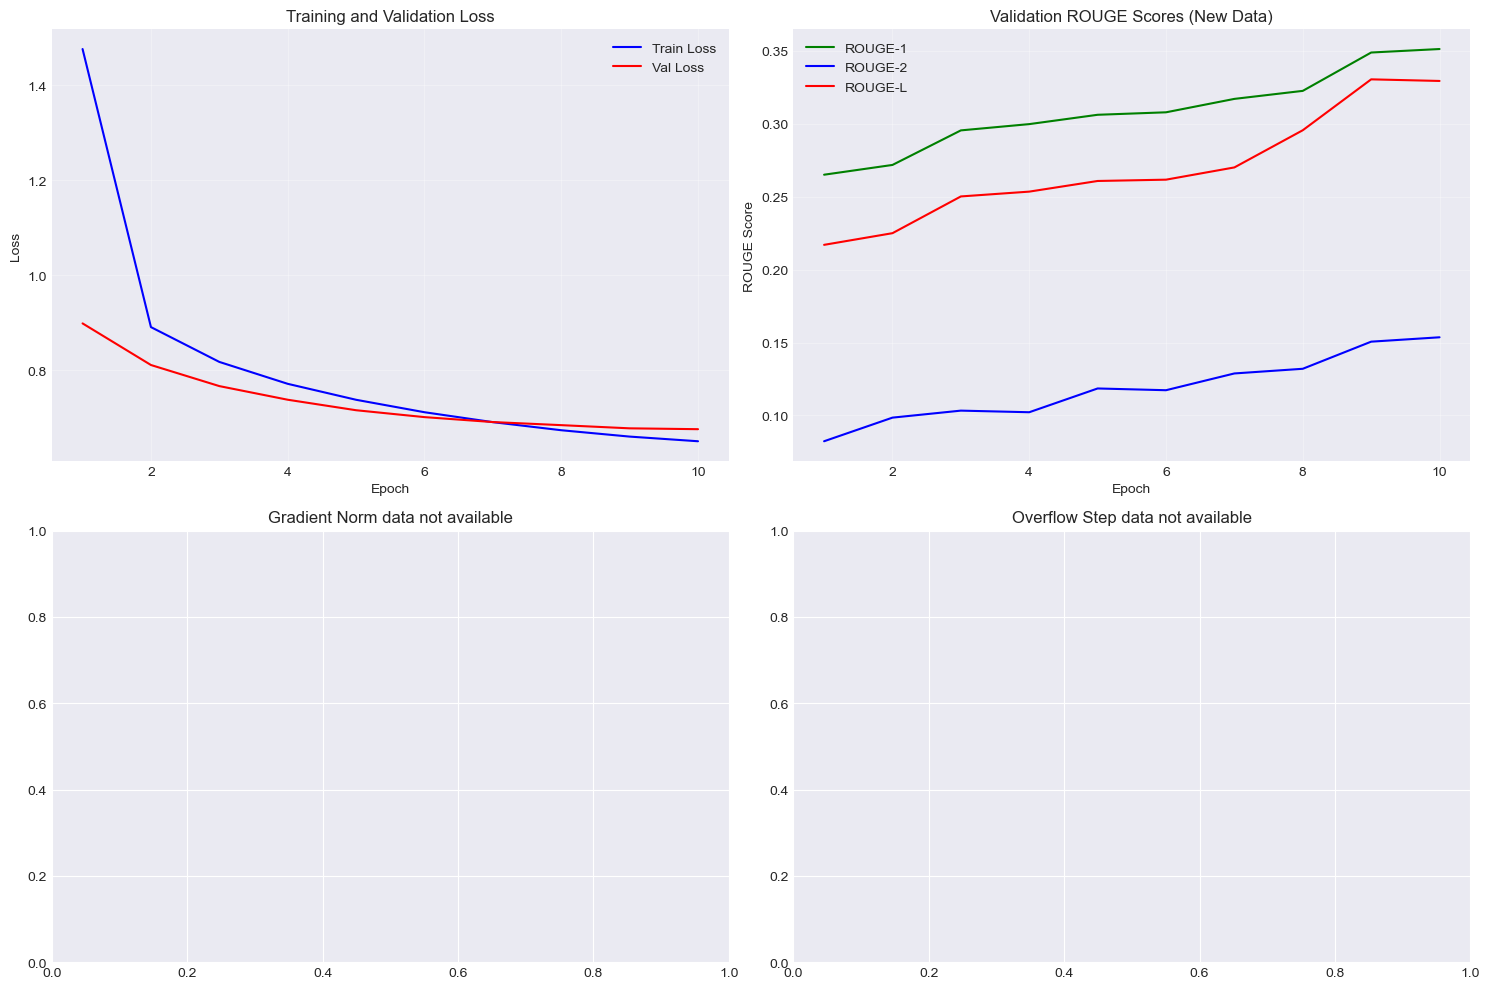

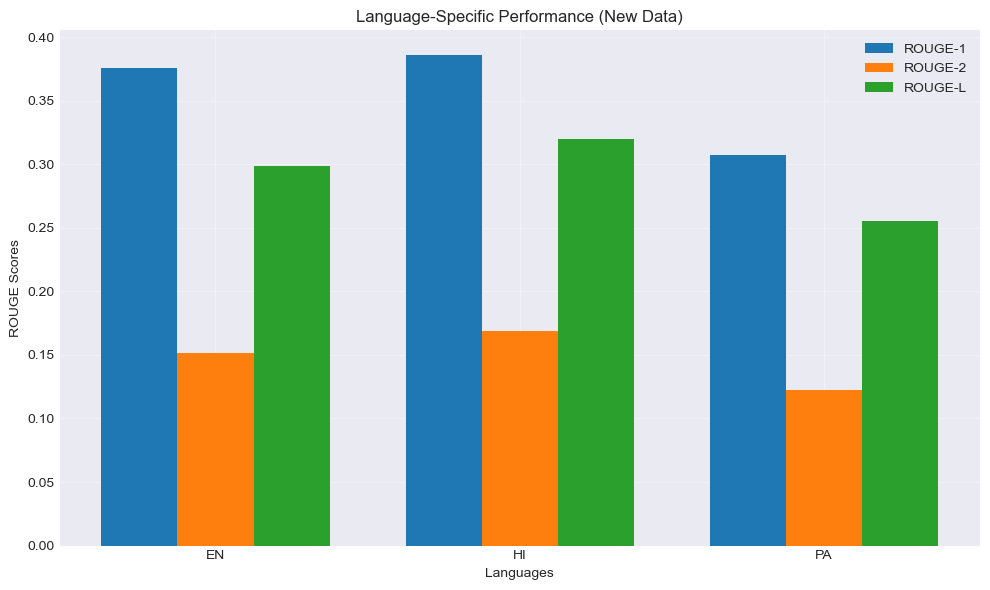

Plots generated successfully.


In [ ]:
plot_training_curves(training_history)
plot_language_performance(language_rouge)


Expert Specialization Analysis

--- Layer 0: base_model.encoder.block.0.layer.1.DenseReluDense.moe_layer ---
Total expert calls: 5921527296

Expert Usage Distribution:
  Expert 0 (EN expert): 959807232 calls ( 16.2%)
  Expert 1 (HI expert): 994403200 calls ( 16.8%)
  Expert 2 (PU expert): 993809344 calls ( 16.8%)
  Expert 3 (shared): 995202624 calls ( 16.8%)
  Expert 4 (shared): 991060736 calls ( 16.7%)
  Expert 5 (shared): 987244032 calls ( 16.7%)

Load Balance Metrics:
  Ideal usage per expert: 16.7%
  Max deviation: 0.5%
  ✅ EXCELLENT balance (deviation < 5%)

Capacity Overflow:
  Total overflow: 29607636 tokens
  Overflow rate: 0.50%
  ✅ EXCELLENT (< 1%)

--- Layer 1: base_model.encoder.block.1.layer.1.DenseReluDense.moe_layer ---
Total expert calls: 5921508352

Expert Usage Distribution:
  Expert 0 (EN expert): 999045248 calls ( 16.9%)
  Expert 1 (HI expert): 1000929728 calls ( 16.9%)
  Expert 2 (PU expert): 986856576 calls ( 16.7%)
  Expert 3 (shared): 963110144 calls ( 16.3%)
 

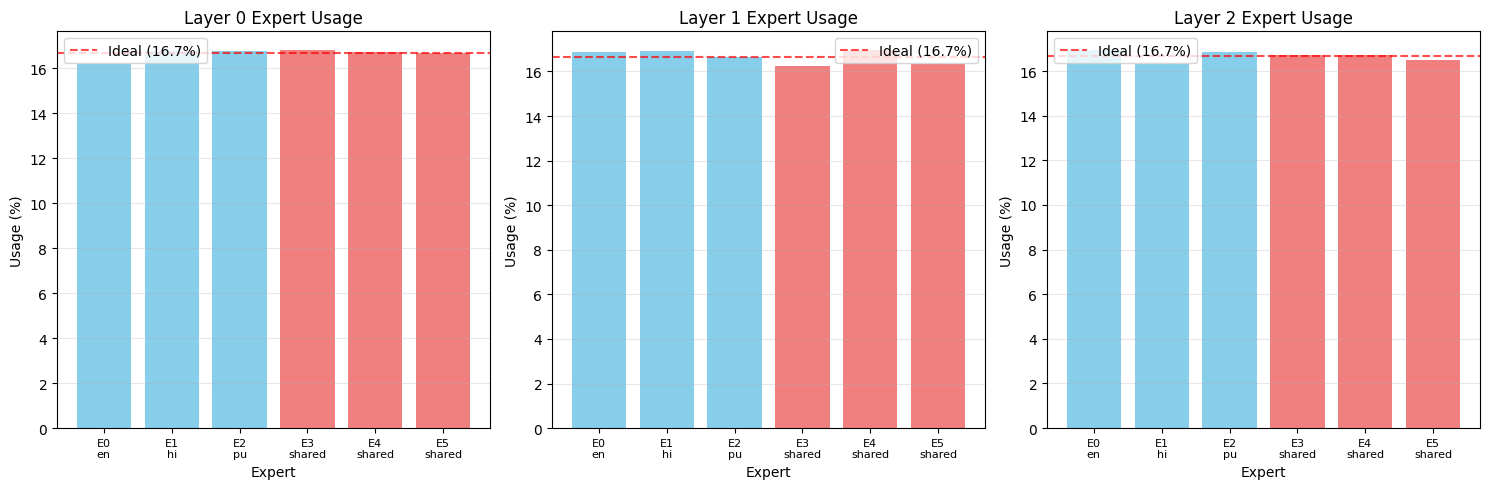

In [31]:
analyze_expert_specialization(model)

In [32]:
# ===== SAVE FINAL RESULTS =====
print("\n" + "="*60)
print("SAVING FINAL TRAINING RESULTS")
print("="*60)

# Save results
final_results = {
    "config": config_dict,
    "training_history": {
        "train_losses": training_history["train_losses"],
        "val_losses": training_history["val_losses"],
        "val_rouge_scores": training_history["val_rouge_scores"],
        "training_time_seconds": training_history["training_time"],
        "training_time_hours": training_history["training_time"] / 3600,
    },
    "test_results": {
        "overall": overall_rouge,
        "per_language": language_rouge,
    },
    "model_info": {
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
    },
    "best_checkpoint": {
        "epoch": training_history.get("best_epoch", None),
        "rougeL": max([s["rougeL"] for s in training_history["val_rouge_scores"]]) if training_history["val_rouge_scores"] else 0,
    },
    "timestamp": datetime.now().isoformat(),
}

results_path = os.path.join(config.checkpoint_dir, "final_results.json")
with open(results_path, "w") as f:
    json.dump(final_results, f, indent=2)

print(f"✓ Results saved to: {results_path}")
print(f"\n📈 Final Test Performance:")
print(f"   ROUGE-1: {overall_rouge['rouge1']:.4f}")
print(f"   ROUGE-2: {overall_rouge['rouge2']:.4f}")
print(f"   ROUGE-L: {overall_rouge['rougeL']:.4f}")
print(f"\n⏱️  Total Training Time: {training_history['training_time']/3600:.2f} hours")
print(f"✓ Best model checkpoint: {config.checkpoint_dir}/best_model/")
print("="*60)


SAVING FINAL TRAINING RESULTS
✓ Results saved to: ./checkpoints/moe_xlsum_20251104_210357/final_results.json

📈 Final Test Performance:
   ROUGE-1: 0.3769
   ROUGE-2: 0.1572
   ROUGE-L: 0.3055

⏱️  Total Training Time: 35.90 hours
✓ Best model checkpoint: ./checkpoints/moe_xlsum_20251104_210357/best_model/
